In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from scipy import stats
import numpy as np
import sklearn.metrics as metrics

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

# Plots have dimension (w,h)
w = 3.5
h = 3.25       

from flows import *

import sys
import os

sys.path.append('../')
from utils.training import *
from utils.losses import *

np.random.seed(666)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m]).T

In [5]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T

In [6]:
n, d = dat.shape

In [7]:
dat_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)

2023-02-20 19:39:58.480176: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 19:39:59.120262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22251 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [8]:
dat_ckpt.restore('dat2/ckpt-79')

In [9]:
dat_smp = dat_target.sample(n)

In [10]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    t_hist = axs[0].hist(truth, bins = 50, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = 50, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

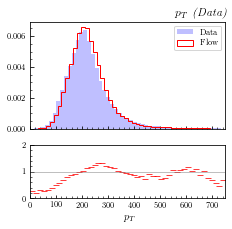

In [11]:
ratio_hist(dat[:, 0], dat_smp[:, 0], 
           labels = ['Data', 'Flow', r'$p_T$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $p_T$ (Data)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/dat2/pT_data.png'
          )

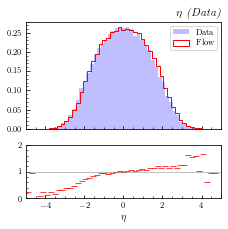

In [12]:
ratio_hist(dat[:, 1], dat_smp[:, 1], 
           labels = ['Data', 'Flow', r'$\eta$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\eta$ (Data)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/dat2/eta_data.png'
          )

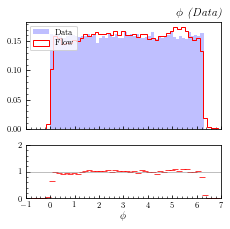

In [13]:
ratio_hist(dat[:, 2], dat_smp[:, 2], 
           labels = ['Data', 'Flow', r'$\phi$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\phi$ (Data)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/dat2/phi_data.png'
          )

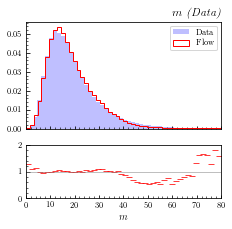

In [14]:
ratio_hist(dat[:, 3], dat_smp[:, 3], 
           labels = ['Data', 'Flow', r'$m$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $m$ (Data)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/dat2/m_data.png'
          )